In [59]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import json
import os
from pathlib import Path

## Visualize image from the dataset

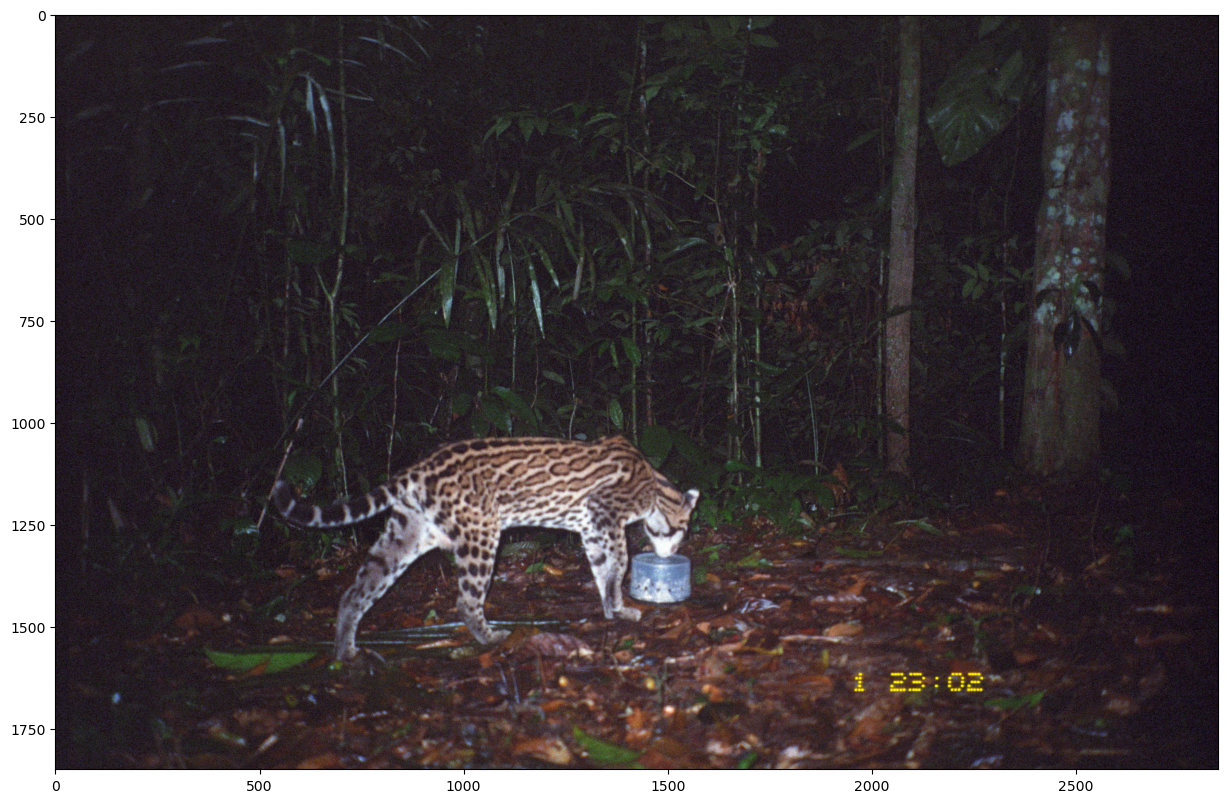

In [ ]:
# Function for plotting one image

def imshow(img):
    fig=plt.figure(figsize=(15, 12))
    im=Image.open(f"../Data/iwildcam-2022/train/{img}")
    plt.imshow(im)

imshow("90dc7792-21bc-11ea-a13a-137349068a90.jpg")

## Prepare the labels and images folder from the `iwildcam-2022` for better structure of images and the bounding boxes.
We will store the images in the following structure:

-- dataset
    -- images
    -- labels

labels folder contains the *txt file for each image, which has one row for each detection `class_id x_center y_center width height`

In [ ]:

# Load the JSON file containing bounding boxes
with open('./filtered_images.json', 'r') as f:
    annotations = json.load(f)

train_df = pd.read_csv('../vansh/final_classes.csv')

# Create directories for YOLO format dataset
os.makedirs('yolo_dataset/images/train', exist_ok=True)
os.makedirs('yolo_dataset/labels/train', exist_ok=True)

# Convert train_df into a dictionary for quick lookup
# This assumes `train.csv` has columns: `file_name` and `class_label`
file_to_class = dict(zip(train_df['image_file'], train_df['class_label']))

In [ ]:
# Iterate over the images in the annotations file and create the file for the yolo format
import logging
from tqdm import tqdm
logging.basicConfig(level=logging.INFO)

for image_data in tqdm(annotations['images'], desc="Filtering.."):

    file_path = image_data['file']
    if file_path.split('/')[0] == 'train': # We only need the train images and not the test images
        file_name = os.path.basename(file_path)

        if file_to_class.get(file_name) is None:
            #logging.warning(f'No class label found for {file_name}')
            continue
        class_label = file_to_class[file_name]

        if class_label is None:
            #logging.warning(f'No class label found for {file_name}')
            continue

        image_label_path = f'datasets/labels/train/{file_name.split(".")[0]}.txt'

        os.makedirs(os.path.dirname(f'datasets/labels/train/{file_name}'), exist_ok=True)
        os.system(f'cp ../Data/iwildcam-2022/{file_path} datasets/images/train/{file_name}')

        with open(image_label_path, 'w') as f_label:

            for detection in image_data['detections']:
                if len(detection) == 0:
                    #logging.warning(f'No detection found for {file_name}')
                    continue
                bbox = detection['bbox']

                x_center, y_center, width, height = bbox

                f_label.write(f"{class_label} {x_center} {y_center} {width} {height}\n")
logging.info('Done')

## We need to change the class labels to the correct 0 based indexing for YOLO

In [ ]:
# Changing the class labels of the labels, to 0 based indexing for Yolo to train

# Original class labels in the dataset (class ID -> class name)
original_class_labels = {
    372: "meleagris ocellata",
    374: "crax rubra",
    96: "aepyceros melampus",
    317: "cephalophus nigrifrons",
    90: "loxodonta africana",
    10: "leopardus pardalis",
    3: "dasyprocta punctata",
    115: "madoqua guentheri",
    380: "mazama temama",
    6: "puma concolor",
    376: "tapirus bairdii",
    371: "urocyon cinereoargenteus",
    24: "panthera onca",
    111: "equus quagga",
    104: "panthera pardus",
    100: "panthera leo",
    154: "panthera tigris"
}  # These are the species we train the model on

# Create a mapping from the original class ID to the new zero-indexed class
class_mapping = {original_class: new_class for new_class, original_class in enumerate(original_class_labels.values())}

# Directory paths
labels_dir = './datasets/labels/train'  # Path to the YOLO labels folder

# Iterate through all the label files in the YOLO labels folder
for label_file in os.listdir(labels_dir):
    if label_file.endswith('.txt'):  # Only process label files
        label_path = os.path.join(labels_dir, label_file)
        
        # Read the label file
        with open(label_path, 'r') as f:
            lines = f.readlines()
        
        # Create a list to store the updated lines
        updated_lines = []
        
        # Process each line in the label file
        for line in lines:
            parts = line.strip().split()  # Split the line into parts: class_id x_center y_center width height
            original_class_id = int(parts[0])  # Original class ID
            
            # Get the corresponding new class ID from the mapping
            if original_class_id in original_class_labels:
                new_class_id = class_mapping[original_class_labels[original_class_id]]
                updated_lines.append(f"{new_class_id} {' '.join(parts[1:])}\n")  # Update the class ID
            else:
                print(f"Warning: Class ID {original_class_id} not found in mapping for file {label_file}")
        
        # Write the updated label file
        with open(label_path, 'w') as f:
            f.writelines(updated_lines)

print("Class label mapping completed and label files updated.")

## Visualize bounding boxes from the annotations file


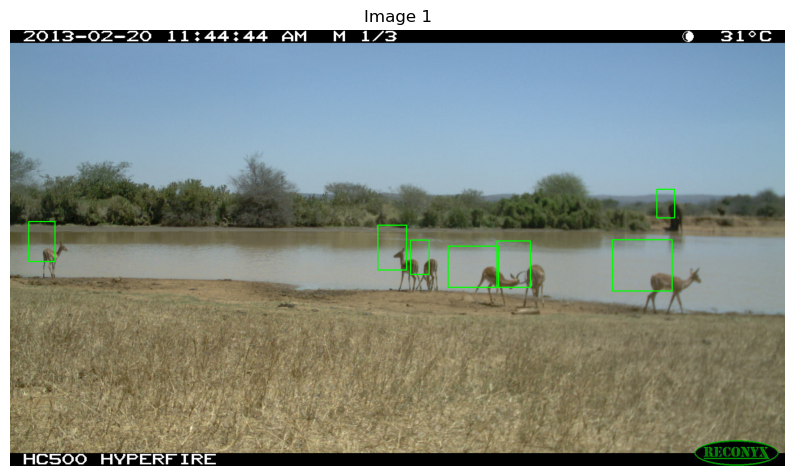

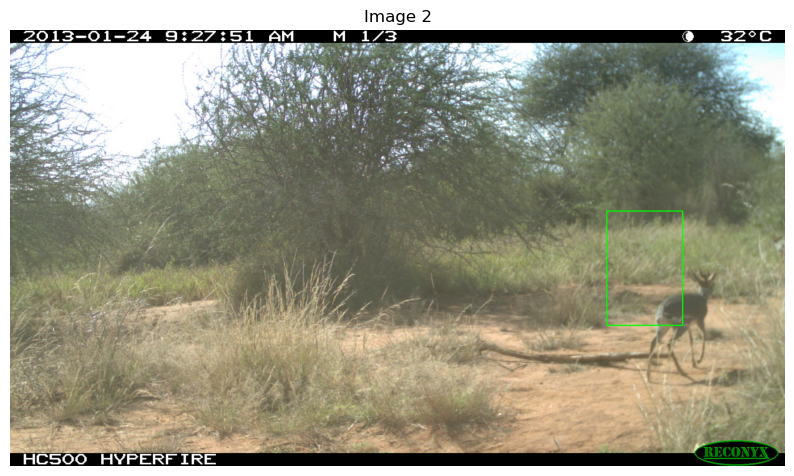

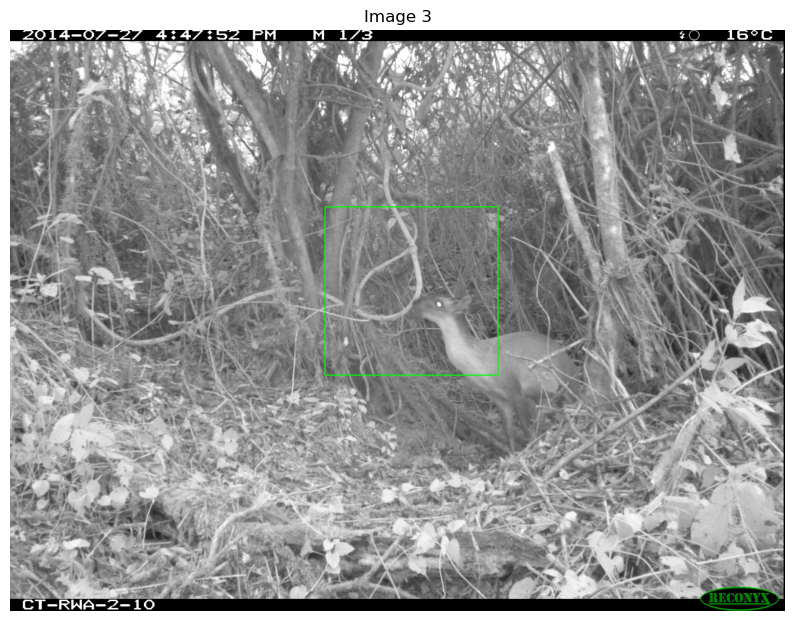

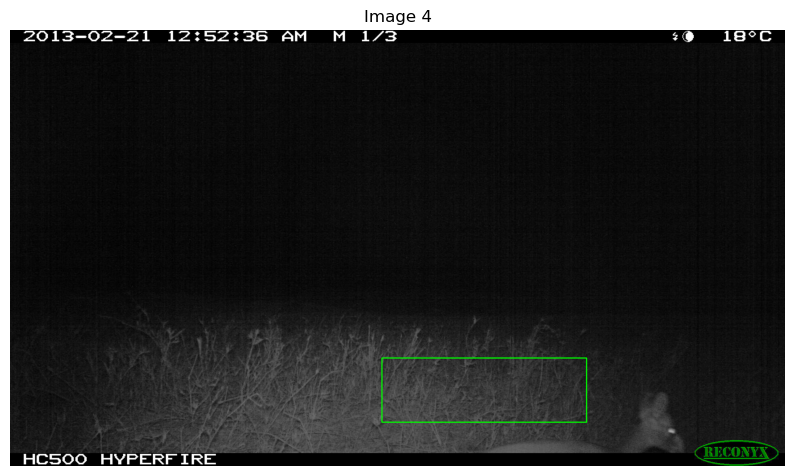

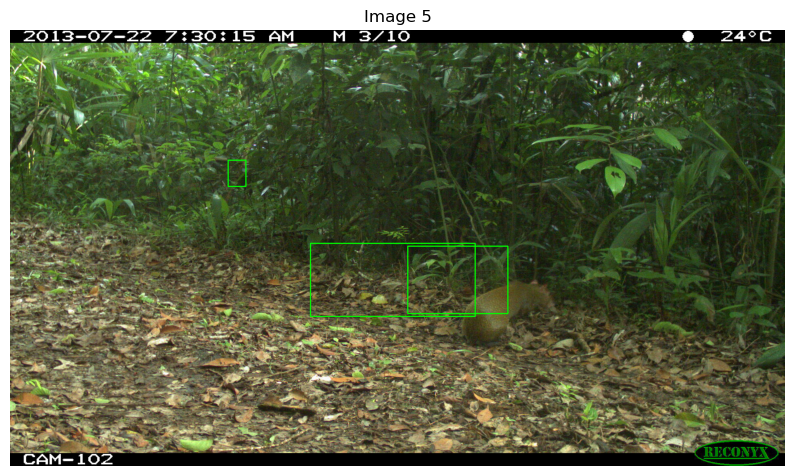

In [ ]:
# Visualizing some images with bounding boxes
import cv2

# Directory paths
images_dir = '../datasets/images/train'  # Path to the YOLO images folder
labels_dir = '../datasets/labels/train'  # Path to the YOLO labels folder

# Get the list of image files
image_files = os.listdir(images_dir)

# Display the first few images with bounding boxes
num_images_to_display = 5

for i, image_file in enumerate(image_files[:num_images_to_display]):
    # Load the image
    image_path = os.path.join(images_dir, image_file)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Load the corresponding label file
    label_path = os.path.join(labels_dir, image_file.replace('.jpg', '.txt'))
    with open(label_path, 'r') as f:
        lines = f.readlines()
    
    # Process each line in the label file
    for line in lines:
        parts = line.strip().split()  # Split the line into parts: class_id x_center y_center width height
        class_id, x_center, y_center, width, height = map(float, parts)
        
        # Convert the bounding box coordinates to pixel values
        image_height, image_width, _ = image.shape
        x_center *= image_width
        y_center *= image_height
        width *= image_width
        height *= image_height
        x1, y1, x2, y2 = int(x_center - width / 2), int(y_center - height / 2), int(x_center + width / 2), int(y_center + height / 2)
        
        # Draw the bounding box on the image
        color = (0, 255, 0)  # Green
        thickness = 2
        image = cv2.rectangle(image, (x1, y1), (x2, y2), color, thickness)
    
    # Display the image
    plt.figure(figsize=(10, 12))
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Image {i + 1}")
    plt.show()

## We can see that the bounding boxes are not as good we need to train the YOLO model, hence we revert to classification only. We only care about the animal species and not the exact location of the animal 

## Extract the images from the dataset with the correct labels

In [ ]:
import csv


# Vansh / Data Preprocessing
# Load the data from your JSON file
with open('path/to/iwildcam2022_training.json') as f:
    data = json.load(f)

# Step 1: Create a dictionary of image IDs to file names
image_id_to_file = {image["id"]: image["file_name"] for image in data["images"]}

# Step 2: Extract image file names and their class labels for category_id > 0
image_data = []
for annotation in data["annotations"]:
    if annotation["category_id"] > 0:  # Only include non-zero category IDs
        image_file = image_id_to_file.get(annotation["image_id"])
        if image_file:
            image_data.append({
                "image_file": image_file,
                "class_label": annotation["category_id"]
            })

# Step 3: Save the extracted data to a CSV file
with open('train.csv', mode='w', newline='') as csv_file:
    writer = csv.DictWriter(csv_file, fieldnames=["image_file", "class_label"])
    writer.writeheader()
    writer.writerows(image_data)


In [ ]:
df = pd.read_csv("train.csv")
train_length = df.shape[0]
train_length

131930

## We use the final_classes.csv file to find the class distribution of the selected classes.

In [ ]:
classes_df = pd.read_csv("../vansh/final_classes.csv")
classes_df['class_label'].value_counts()

class_label
372                                            12689
374                                            10353
96                                              8283
317                                             6887
90                                              3438
10                                              3356
3                                               3282
115                                             3158
380                                             2897
6                                               2484
376                                             2440
371                                             2289
24                                              2135
111                                             2083
104                                               64
100                                               59
154                                               54
1008ba268a4-21bc-11ea-a13a-137349068a90.jpg        1
Name: count, dtype: int64

## Running a Pre-Trained Yolo Classification model on a test image

We import the SoTA Yolo11-cls model which is trained on ImageNet dataset to see the classification accuracy.



image 1/1 /home/guest_quest_70/UMC_Project_Group_5/vansh/../classification_dataset/train/panthera onca/8a0a5b8c-21bc-11ea-a13a-137349068a90.jpg: 224x224 leopard 0.68, jaguar 0.31, snow_leopard 0.01, cheetah 0.00, eel 0.00, 5.0ms
Speed: 17.9ms preprocess, 5.0ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)
ultralytics.engine.results.Results object with attributes:

boxes: None
keypoints: None
masks: None
names: {0: 'tench', 1: 'goldfish', 2: 'great_white_shark', 3: 'tiger_shark', 4: 'hammerhead', 5: 'electric_ray', 6: 'stingray', 7: 'cock', 8: 'hen', 9: 'ostrich', 10: 'brambling', 11: 'goldfinch', 12: 'house_finch', 13: 'junco', 14: 'indigo_bunting', 15: 'robin', 16: 'bulbul', 17: 'jay', 18: 'magpie', 19: 'chickadee', 20: 'water_ouzel', 21: 'kite', 22: 'bald_eagle', 23: 'vulture', 24: 'great_grey_owl', 25: 'European_fire_salamander', 26: 'common_newt', 27: 'eft', 28: 'spotted_salamander', 29: 'axolotl', 30: 'bullfrog', 31: 'tree_frog', 32: 'tailed_frog', 33: 'loggerh

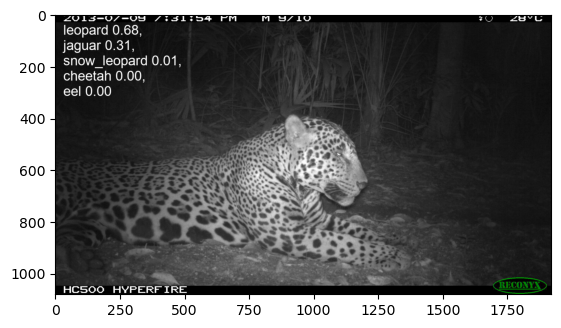

In [57]:
from ultralytics import YOLO

model = YOLO("yolo11n-cls.pt")  # initialize model
results = model("../classification_dataset/train/panthera onca/8a0a5b8c-21bc-11ea-a13a-137349068a90.jpg")  # perform inference

print(results[0])  # print results
# Show the image with bounding boxes using Matplotlib
fig, ax = plt.subplots()
ax.imshow(results[0].plot())  # Display the image with annotations
plt.show()

## We can see that the pre-trained model, gives pretty accurate results but not on a species level, we use transfer learning to further train the model on our custom dataset